In [42]:
import numpy as np, pandas as pd, scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from time import strptime

# Introduction

The goal of this notebook is to implement an interpretable epidemiological model of the covid-19 spread, with the intent of learning how population dynamics work. While the model here is largely theoretical it can at least help us better understand the current rapid rates at which things are changing right before us on a daily basis. As such, it is not at all to be taken as an accurate predictor but rather an educational tool. Feel free to use this in your own research/learning, add extensions to the model, implement scenario analyses, etc. Hopefully it helps as a starting point.

The first part discusses some of the math behind the model, if this is of no interest to you, feel free to skip to the Simulation part onward.

## Credits

While studying the current situation, I quickly came across many online communities taking initiatives, helping in any way they can to battle the pandemic. In particular, thanks to the Kaggle community for opening the global forecasting challenge recently (data sources provided by John Hopkins CSSE).

https://www.kaggle.com/c/covid19-global-forecasting-week-1

Data Source

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

Also to the following kernels for some ideas and functionalities

https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions

https://www.kaggle.com/anjum48/seir-model-with-intervention


# Data

`data.csv` shows confirmed cases and fatalities per country per state since day 0. This notebook works with data up to March 23, 2020.

`population_data.csv` shows population by country by state.


# Vanilla Model

The SEIR model is a widely known epidemiological model of disease transmission within a population. It considers four main groups: Susceptible, Exposed, Infectious, Recovered (S, E, I, R). It is an extension of the SIR model in that the exposed group has come into contact with an infectious member but have not yet become infectious themselves, thereby considering the realistic assumption that the disease has some incubation period. If we consider $S_t,E_t,I_t,R_t$ to be the number of members of these respective groups at any time $t$, the evolution of these four groups can be modeled with the following set of Ordinary Differential Equations (ODEs):

\begin{align}
    &\frac{dS_t}{dt} =-\alpha S_t I_t \label{eq1}\tag{1} \\
    &\frac{dE_t}{dt} =\alpha S_t I_t -\beta E_t \label{eq2}\tag{2} \\
    &\frac{dI_t}{dt} = \beta E_t - \gamma I_t \label{eq3}\tag{3} \\
    &\frac{dR_t}{dt} =\gamma I_t \label{eq4}\tag{4}\\
    &N = S_t + E_t + I_t + R_t \label{eq5}\tag{5}
\end{align}

where each equation explains the change in size of each group per unit time as they transition from one to another over time; the transitions through the states are strictly forward $(S \to E \to I \to R)$. Note that group $R$ includes both recoveries and fatalities together.

This model assumes a fixed population size $N$ with no immigration, no disease intervention, that natural birth and death rates are equal, and of course the most strict assumption that all members are uniformly well mixed.

For further reading:

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model


## Extended Model

This notebook will consider the SEIR model with two extensions:

$\textbf{1) Disease intervention.}$ We are all familiar now with some of the disease interventions that have been implemented recently: social distancing, close non-essential business, restrict immigration, quaranties, etc. What all of these aim to achieve is to minimize the average number of members that every member comes into contact with per unit time, ultimately minimizing the reproduction rate of the disease. Given the number of people that the average member of a population comes into contact with in normal circumstances, we can implement a reproduction function which decays this number over time as the government intervenes.

$\textbf{2) Split R into two groups.}$ Since we are very interested in the total confirmed cases and fatalities, we can divide the R group into two mutually exclusive groups: Recovered (R) and Deceased (D).


## Parameter interpretations

## $\alpha$

In equation $(1)$ $\alpha$ describes the rate at which susceptible members become truly exposed per unit time. $\alpha$ from $(1)$ can be expanded further as a function of a few things. If we consider:

$r$ is the average number of people that an infectious person comes into contact with during infection
<br>
$\frac{S}{N}$ is the percentage of the population currently susceptible
<br>
$\rho$ is the probability that the disease is transmitted from an infectious member to a susceptible member given that they contacted
<br>
$T$ is the average time it takes for an infectious member to transition into the $R$ group

It follows that given $I_t$ infectious members and $S_t$ members currently susceptible, we would expect the number of suseptible members becoming exposed per unit time to be

\begin{align}
    \frac{\rho \times r \times \frac{S_t}{N} \times I_t}{T}
\end{align}

which implies that

\begin{align}
    \alpha=\frac{\rho r}{N T}
\end{align}

To implement extention 1) we can consider $r$ no longer to be constant, but some decay function overtime described above, $r_t$. In particular we consider a modified Hill decay function.

\begin{align}
    r(t;k,L)=\frac{r_0}{1+(\frac{t}{L})^k}
\end{align}

We now have a time dependent $\alpha$

\begin{align}
    \alpha_t = \frac{\rho \times r_t }{NT}
\end{align}

In this notebook we will fix $k=2.5$ and $L=25$ strictly for illustration, and these can be either estimated from the data or tuned by the user to simulate different intervention scenarios.


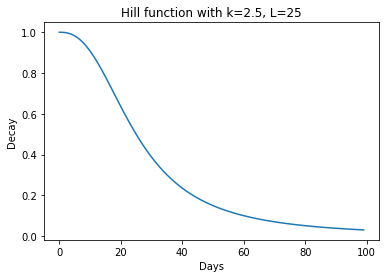

In [3]:
k, L = 2.5, 25
hill = lambda t : 1 / (1 + (t/L)**k)
times = np.arange(100)

plt.plot(hill(times))
plt.ylabel('Decay')
plt.xlabel('Days')
plt.title('Hill function with k=2.5, L=25')
plt.show()

To implement extension 2) we can consider splitting $R$ into two mutually exclusive groups: $R$ (recoveries from the disease) and $D$ (fatalities from the disease). If we consider

$T_R$: the average time for $I$ member to recover
<br>
$T_F$: the average time to fatality of $I$ member
<br>
$p_R$: probability of infectious member recovering
<br>
$p_F$: probability of infectious member dying

It follows that given $I_t$ infectious members (who will recover) and $S_t$ members currently susceptible, we would expect the number of suseptible members becoming exposed per unit time by future survivors to be

\begin{align}
    \frac{\rho \times r_t \times \frac{S_t}{N} \times p_R \times I_t}{T_R}
\end{align}

which implies that

\begin{align}
    \alpha_t^R = \frac{\rho r_t p_R }{NT_R}
\end{align}

And we would expect the number of suseptible members becoming exposed per unit time by those who will die in the future to be

\begin{align}
    \frac{\rho \times r_t \times \frac{S_t}{N} \times p_F \times I_t}{T_F}
\end{align}

which implies that

\begin{align}
    \alpha_t^F = \frac{\rho r_t p_F }{NT_F}
\end{align}

## $\beta$

In equation $(2)$ $\beta$ describes the rate at which exposed members become infected per unit time. Given that an exposed member has successfully been transmitted the disease, then assuming they will become infectious after incubation period $T_I$ with probability 1:

\begin{align}
    \beta = \frac{1}{T_I}
\end{align}

## $\gamma$

In equation $(3)$ $\gamma$ describes the rate at which infectious members transition into $R$. We know some will be recoveries and some will be fatalities, so the ones who will recover will do so on average in $T_R$ days with probability $p_R$ and the ones who will die will do so on average in $T_F$ days with probability $p_F$

\begin{align}
    \gamma = \frac{p_R}{T_R} + \frac{p_F}{T_F}
\end{align}


## Final Model

\begin{align}
    &\frac{dS_t}{dt} = -\frac{\rho r_t p_R }{NT_R} S_t I_t - \frac{\rho r_t p_F }{NT_F} S_t I_t \label{eq1}\tag{1} \\
    &\frac{dE_t}{dt} =\frac{\rho r_t p_R }{NT_R} S_t I_t + \frac{\rho r_t p_F }{NT_F} S_t I_t -\frac{1}{T_I}E_t \label{eq2}\tag{2} \\
    &\frac{dI_t}{dt} = \frac{1}{T_I}E_t - \frac{p_R}{T_R}I_t - \frac{p_F}{T_F}I_t \label{eq3}\tag{3} \\
    &\frac{dR_t}{dt} = \frac{p_R}{T_R}I_t \label{eq4}\tag{4}\\
    &\frac{dD_t}{dt} = \frac{p_F}{T_F}I_t \label{eq5}\tag{5}\\
    &N = S_t + E_t + I_t + R_t + D_t \label{eq6}\tag{6}
\end{align}

We will be modeling the fatalities $D$ and the total confirmed cases, the total number of distinct confirmed cases (survivals and fatalities) at time $t$, $C_t$, can be computed as

\begin{align}
    C_t = \sum_{\tau=1}^t I_{\tau} + R_{\tau} + D_{\tau} - I_{\tau-1} - R_{\tau-1} - D_{\tau-1}
\end{align}

$(S_0,E_0,I_0,R_0,D_0)$ are the initial conditions at $t=0$.


# Data

In [ ]:
train = pd.read_csv('../covid19/train.csv')
populations = pd.read_csv('../covid19/population_data.csv')
populations = populations.drop(columns=['Type']).set_index('Name').transpose()
populations = populations.to_dict()
train.columns = ['Id', 'State', 'Country', 'Lat', 'Long', 'Date', 'ConfirmedCases', 'Fatalities']

# Define some functions

In [5]:
# visualization function for later

def multi_plot(M, susceptible = True, labels=False, interventions=False):
    n = M.shape[0]
    CC0 = M[2,0]+M[3,0]+M[4,0]
    CCases = np.diff(M[2]+M[3]+M[4], prepend=CC0).cumsum()
    Deaths = M[4]
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 1, 1.25, 1], ylabel='# of People')
    ax2 = fig.add_axes([0.1, 0, 1.25, 1], ylabel='# of People')    
    if susceptible == True:
        rows=range(0,n)
    else:
        rows=range(1,n)
    for ii in rows:
        if labels == False:
            ax1.plot(M[ii])
        else:
            ax1.plot(M[ii], label = labels[ii])
    if interventions==False:
        ax1.set_title('Time Evolution without intervention')
    else:
        ax1.set_title('Time Evolution with intervention')
        for action, day in zip(list(interventions.keys()), [interventions[kk]['day'] for kk in list(interventions.keys())]):
            ax1.axvline(x=day,label=action, linestyle='--')
            ax2.axvline(x=day,label=action, linestyle='--')
    ax1.legend(loc='best')
    ax2.plot(CCases, label='ConfirmedCases', color='brown')
    ax2.plot(Deaths, label='Deaths', color='black')
    ax2.legend(loc='best')
    ax2.set_xlabel('Days')
    plt.show()

categories = ['Susceptible','Exposed','Infected','Recovered','Deceased']

In [19]:
# Vanilla ODE model for simulation

def reproduction(t):
    intervention_days = [interventions[kk]['day'] for kk in list(interventions.keys())]
    reproduction_rates = [interventions[kk]['reproduction_rate'] for kk in list(interventions.keys())]
    ix=np.where(np.array(intervention_days)<t)[0]
    
    if len(ix)==0:
        return R0
    else:
        return reproduction_rates[ix.max()]


def dS_dt(S, I, reproduction_t, alpha1, alpha2):
    return -alpha1*reproduction_t*S*I -alpha2*reproduction_t*S*I

def dE_dt(S, I, E, reproduction_t, alpha1, alpha2, beta):
    return alpha1*reproduction_t*S*I + alpha2*reproduction_t*S*I - beta*E

def dI_dt(E, I, beta, gamma, psi):
    return beta*E - gamma*I - psi*I

def dR_dt(I, gamma):
    return gamma*I

def dD_dt(I, psi):
    return psi*I


def ODE_model(t, y, Rt, alpha1, alpha2, beta, gamma, psi):

    if callable(Rt):
        reproduction_t = Rt(t)
    else:
        reproduction_t = Rt
    
    S, E, I, R, D = y
    St = dS_dt(S, I, reproduction_t, alpha1, alpha2)
    Et = dE_dt(S, I, E, reproduction_t, alpha1, alpha2, beta)
    It = dI_dt(E, I, beta, gamma, psi)
    Rt = dR_dt(I, gamma)
    Dt = dD_dt(I, psi)
    return [St, Et, It, Rt, Dt]

# Simulation under Vanilla Model

Here we will look at what the evolution of SEIRD will look like under intervention. Interventions such as quarantines and social distancing reduce the number of members an infected person has contact with which can result in a slower rate of reproduction of the disease overtime.


In [20]:
# Fix some population parameters for simulation (refer to previous sections for interpretations)

N = 1000 # population size
T_inc = 10 # days for average incubation
T_rec = 14 # days for average recovery
T_die = 10 # days for average infection duration given death
R0 = 5 # average number of contacts an infected person has per day
tau = 0.2 # probability of transmission given S <-> I contact
p_live = 0.95 # average survival rate
p_die = 0.05 # average pmortality rate
ndays = 100 # number of days simulated

# ODE parameters
alpha1 = tau*p_live/N # average % of susceptible people who get infected by survivor
alpha2 = tau*p_die/N # average % of susceptible people who get infected by non-survivor
beta = 1/T_inc # transition rate of incubation to infection
gamma = p_live/T_rec # transition rate of infection to recovery
psi = p_die/T_die # transition rate of infection to mortality

y0 = [N-1, 1, 0, 0, 0] # initial conditions
t_span = [0, ndays] # dayspan to evaluate
t_eval = np.arange(ndays) # days to evaluate


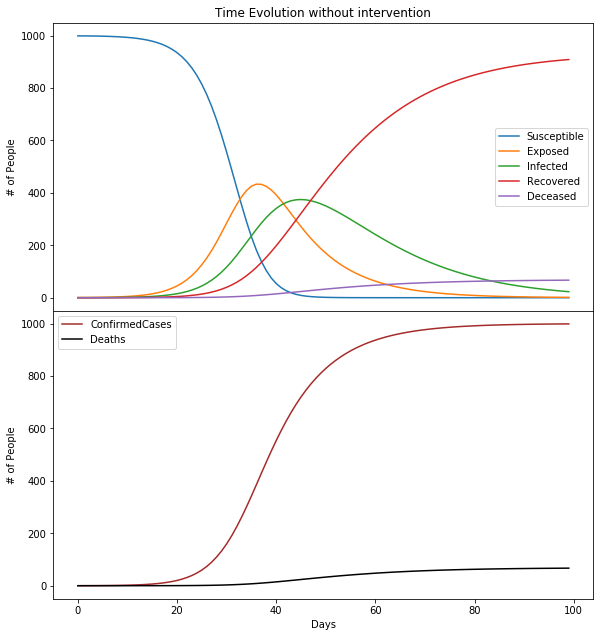

In [21]:
# Here we look at the evolution given no intervention

interventions = {}

solution = sp.integrate.solve_ivp(fun = ODE_model, t_span = t_span, t_eval = t_eval, y0 = y0, 
                                  args = (R0, alpha1, alpha2, beta, gamma, psi))

Y = np.maximum(solution.y,0)

multi_plot(Y, labels=categories)

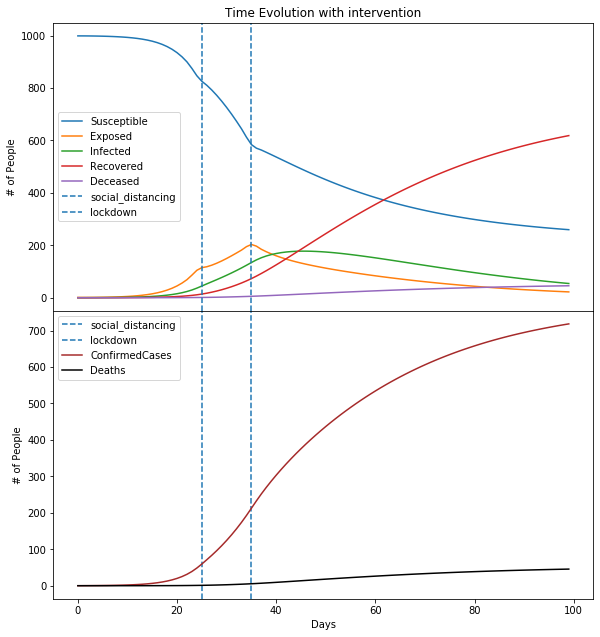

In [22]:
# In this simulation, we look at the evolution given 2 interventions
# we may consider what happens to the process after some intervention, which
# reduces the average number of contacts an infected person has per day
# such as social distancing and lockdown

interventions = {'social_distancing':{'day':25, 'reproduction_rate':2},
                 'lockdown':{'day':35, 'reproduction_rate':.5}}

solution = sp.integrate.solve_ivp(fun = ODE_model, t_span = t_span, t_eval = t_eval, y0 = y0, 
                                  args = (reproduction, alpha1, alpha2, beta, gamma, psi))

Y = np.maximum(solution.y,0)

multi_plot(Y, labels=categories, interventions=interventions)


One of the key things to notice is that the effects of any measure will show a lag, and this is partly due to the incubation period of the disease. At the time when lockdown is implemented, total number of infectious people was less than 200 while those who were exposed and incubating the virus was already well over 200, this is why we see the confirmed cases continue to increase for some time after intervention. 

In the first scenario with no intervention, we can see that the system had reached equilibrium well before day 100, in other words the entire population became infectious at some point. With intervention, we see that equilibrium has not yet been reached as the rates of transmission have significantly reduced. In fact, after 500 days there will be a portion of the population that never became exposed at all!!!

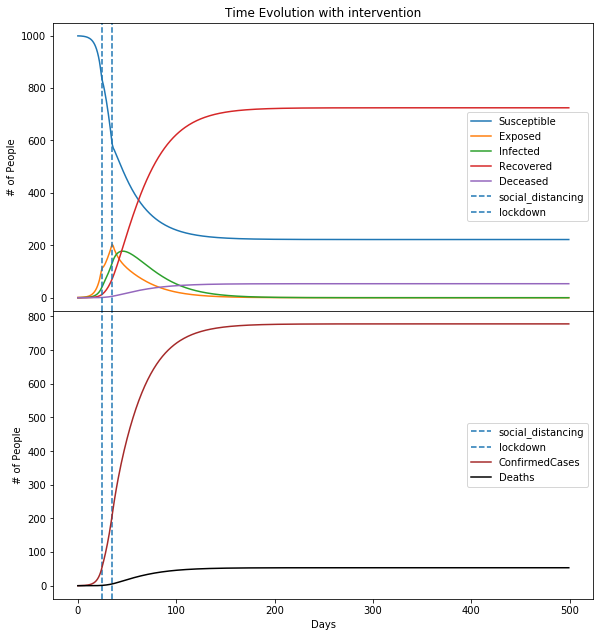

In [24]:
ndays = 500
t_span = [0, ndays] # dayspan to evaluate
t_eval = np.arange(ndays) # days to evaluate

solution = sp.integrate.solve_ivp(fun = ODE_model, t_span = t_span, t_eval = t_eval, y0 = y0, 
                                  args = (reproduction, alpha1, alpha2, beta, gamma, psi))

Y = np.maximum(solution.y,0)

multi_plot(Y, labels=categories, interventions=interventions)


# Define Extended Model

In [25]:
def dS_dt(S, I, alpha1_t, alpha2_t):
    return -alpha1_t*S*I -alpha2_t*S*I

def dE_dt(S, I, E, alpha1_t, alpha2_t, beta):
    return alpha1_t*S*I + alpha2_t*S*I - beta*E

def dI_dt(E, I, beta, gamma, psi):
    return beta*E - gamma*I - psi*I

def dR_dt(I, gamma):
    return gamma*I

def dD_dt(I, psi):
    return psi*I


def ODE_model(t, y, alpha1t, alpha2t, beta, gamma, psi):

    alpha1_t = alpha1t(t)
    alpha2_t = alpha2t(t)
    
    S, E, I, R, D = y
    St = dS_dt(S, I, alpha1_t, alpha2_t)
    Et = dE_dt(S, I, E, alpha1_t, alpha2_t, beta)
    It = dI_dt(E, I, beta, gamma, psi)
    Rt = dR_dt(I, gamma)
    Dt = dD_dt(I, psi)
    return [St, Et, It, Rt, Dt]

# Model Fit

In [26]:
def loss(theta, data, population, k, L, nforecast=0, error=True):
    alpha1_0, alpha2_0, beta, gamma, psi = theta
    
    Infected_0 = data.ConfirmedCases.iloc[0]
    ndays = nforecast
    ntrain = data.shape[0]
    y0 = [(population-Infected_0)/population, 0, Infected_0/population, 0, 0]
    t_span = [0, ndays] # dayspan to evaluate
    t_eval = np.arange(ndays) # days to evaluate
    
    def a1_t(t):
        return alpha1_0 / (1 + (t/L)**k)

    def a2_t(t):
        return alpha2_0 / (1 + (t/L)**k)

    sol = sp.integrate.solve_ivp(fun = ODE_model, t_span = t_span, t_eval = t_eval, y0 = y0, 
                                 args = (a1_t, a2_t, beta, gamma, psi))
    
    pred_all = np.maximum(sol.y, 0)
    ccases_pred = np.diff((pred_all[2] + pred_all[3] + pred_all[4])*population, n = 1, prepend = Infected_0).cumsum()
    deaths_pred = pred_all[4]*population
    ccases_act = data.ConfirmedCases.values
    deaths_act = data.Fatalities.values
    
    if ccases_act[-1]<ccases_act[-2]:
        ccases_act[-1]=ccases_act[-2]
    if deaths_act[-1]<deaths_act[-2]:
        deaths_act[-1]=deaths_act[-2]
    
    weights =  np.exp(np.arange(data.shape[0])/10)/np.exp((data.shape[0]-1)/10) 

    ccases_rmse = np.sqrt(mean_squared_error(ccases_act, ccases_pred[0:ntrain], sample_weight=weights))
    deaths_rmse = np.sqrt(mean_squared_error(deaths_act, deaths_pred[0:ntrain], sample_weight=weights))

    loss = np.mean((ccases_rmse, deaths_rmse))
    
    if error == True:
        return loss
    else:
        return loss, ccases_pred, deaths_pred

### DISCLAIMER: 
First as this is a fairly recent outbreak, there is still very little data available (as of March 25 of writing this). Second as this notebook is only considering $\textbf{one model}$ for illustrative purposes only, there will be no validation, only fitting on the available training data. This is a work in progress and I will play around with a few more models as time goes on.

In [27]:
train['location'] = train['State'].fillna(train['Country'])
locations=list(train['location'].drop_duplicates())
train.set_index(['location', 'Date'], inplace=True)


In [30]:
train.head()

Id State      Country   Lat  Long  ConfirmedCases  \
location    Date                                                            
Afghanistan 2020-01-22   1   NaN  Afghanistan  33.0  65.0             0.0   
            2020-01-23   2   NaN  Afghanistan  33.0  65.0             0.0   
            2020-01-24   3   NaN  Afghanistan  33.0  65.0             0.0   
            2020-01-25   4   NaN  Afghanistan  33.0  65.0             0.0   
            2020-01-26   5   NaN  Afghanistan  33.0  65.0             0.0   

                        Fatalities  
location    Date                    
Afghanistan 2020-01-22         0.0  
            2020-01-23         0.0  
            2020-01-24         0.0  
            2020-01-25         0.0  
            2020-01-26         0.0

In [ ]:
parms0 = [1.5, 1.5, 0.5, 0.05, 0.001]
bnds = ((0.001, None), (0.001, None), (0, 10), (0, 10), (0, 10))

In [56]:
def fit_ODE_model(location, k, L):
        
    dat = train.loc[location].query('ConfirmedCases > 0')
    nforecast = 75
    population = populations[location]['Population']
    n_infected = train['ConfirmedCases'].iloc[0]
        
    res = sp.optimize.minimize(fun = loss, x0 = parms0, 
                               args = (dat, population, k, L, nforecast),
                               method='L-BFGS-B', bounds=bnds)
    
    dates_all = [str(datetime.strptime(dat.index[0], '%Y-%m-%d') + timedelta(days = ii))[0:10] for ii in range(nforecast)]
    
    err, ccases_pred, deaths_pred = loss(theta = res.x, data = dat, population = population, k=k, L=L, 
                                         nforecast=nforecast, error=False)
    
    predictions = pd.DataFrame({'ConfirmedCases': ccases_pred,
                                'Fatalities': deaths_pred}, index=dates_all)
    
    train_true = dat[['ConfirmedCases',  'Fatalities']]
    predictions.columns = ['ConfirmedCases_pred',  'Fatalities_pred']

    plot_df = pd.merge(predictions,train_true,how='left', left_index=True, right_index=True)

    plt.plot(plot_df.ConfirmedCases_pred.values, color='green',linestyle='--', linewidth=0.5, label='Confirmed Cases (pred)')
    plt.plot(plot_df.Fatalities_pred.values, color='blue',linestyle='--', linewidth=0.5, label='Fatalities (pred)')
    plt.plot(plot_df.Fatalities.values, color='red', label='Fatalities (real)')
    plt.plot(plot_df.ConfirmedCases.values, color='orange', label='Confirmed Cases (real)')
    plt.title(location)
    plt.xlabel('Days since first case in '+location)
    plt.ylabel('Confirmed Cases')
    plt.legend(loc='best')
    plt.show()        
    
    print(res.x)


# Vizualize

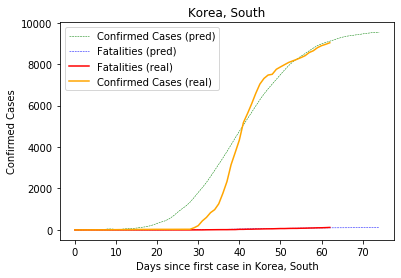

[0.65619856 0.65619856 0.28482049 0.30438426 0.00348863]


In [57]:
fit_ODE_model('Korea, South', k, L)

Just an observation that the parameter corresponding to $\frac{p_F}{T_F}=0.00348863$. This may be in line with some current estimates that mortality rates can be as high as $5 \%$ and incubation time is 14 days $(0.05/14 = 0.0035714)$. Much more analysis must be done to estimate uncertainties in these parameters from the data. Also keep in mind that both the numerator and denominator here can change substantially across countries (different countries implement different interventions and have different medical resources, population demographics, etc).

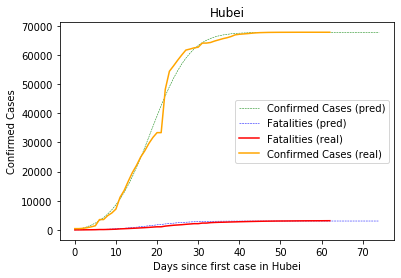

[3.63728519 3.63728519 0.49707399 4.70302581 0.22036337]


In [58]:
fit_ODE_model('Hubei', k, L)

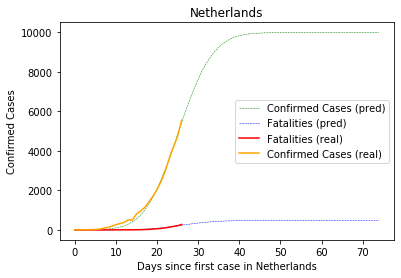

[1.33379485 1.33379485 0.7750969  1.24937234 0.0628374 ]


In [59]:
fit_ODE_model('Netherlands', k, L)

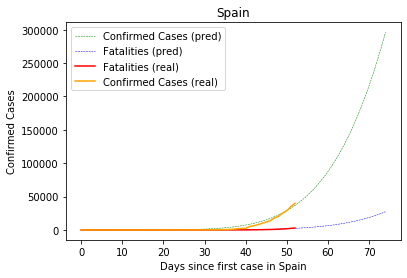

[9.69582934e+00 9.69582934e+00 4.83137904e-03 0.00000000e+00
 9.23938191e-03]


In [60]:
fit_ODE_model('Spain', k, L)

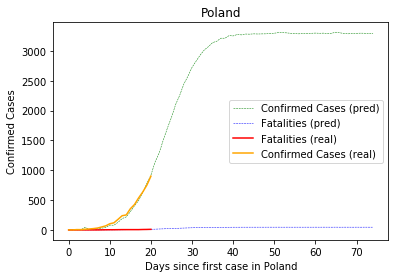

[0.8521554  0.8521554  1.04906515 0.87469644 0.01238707]


In [61]:
fit_ODE_model('Poland', k, L)

# Conclusions

In practice, fitting ODE models can be very tricky. They are very sensitive to initial conditions and especially in this case because while the initial condition can be only 1 infected person, we are solving the ODE system with a susceptile (group S) population size of sometimes 50M+ people, and so the data we see so far is only a very recent evolution that has only reached a small portion of the total population, and given only a few weeks of more data we may start to see some very different dynamics. 

The model, while considering intervention, does not account for many other significant factors such as sub populations, demographics, population densities in different areas, health resources (ICU beds, ventilators), how temperatures and local conditions can affect the spread, the list goes on.

A possible extension of this particular model will be do expand on the intervention model and estimate its parameters from the data. This may make the loss function multi-modal and sensitive to incremental parameter changes given the above formulation. Furthermore, since the goal here was to implement and interpretable model, we may be more interested in sampling model parameters from a posterior distribution to obtain statistically principled uncertainties rather than just point estimates. 